In [8]:
!pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip "/content/input"

In [10]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/input", output="output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 629 files [00:00, 874.88 files/s]


In [11]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential,Model, load_model
from tensorflow.keras.optimizers import Adam,SGD 
from keras.callbacks import ReduceLROnPlateau 
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout
import warnings
warnings.filterwarnings("ignore")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.2)

train_generator=train_datagen.flow_from_directory(
      '/content/output/train',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/output/val',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    "/content/output/test", 
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 

Found 403 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Found 67 images belonging to 3 classes.


In [13]:
train_generator.class_indices

{'bank of america': 0,
 'bank of the west bnp paribas': 1,
 'wells fargo business choice checking': 2}

In [14]:
#mapping encoded values to class labels
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'bank of america',
 1: 'bank of the west bnp paribas',
 2: 'wells fargo business choice checking'}

In [15]:
# Hyperparameters:
input_shape = (150,150,3)
batch_size = 32
lr = 0.001
n_class = 6
epochs =20
adam = Adam(lr = lr, beta_1 = 0.9, beta_2 =0.999,amsgrad =False,epsilon =1e-7)

In [16]:
#ReduceLROnPlateau to reduce LR 
lrr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,factor =0.25,min_lr = 0.000003, verbose =1)

In [17]:
#Creating early stopping callback
from  keras.callbacks import EarlyStopping
early_stopping =EarlyStopping(monitor = 'val_accuracy', patience=3) 
#stop the training process if there is no change in val_accuracy for 3 rounds

In [18]:
# Import the model  
from tensorflow.keras.applications.mobilenet import MobileNet


pre_trained_model = MobileNet(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  

17235968/17225924 [==============================] - 0s 0us/step


In [29]:
from tensorflow.keras import layers
x = layers.Dropout(0.3)(pre_trained_model.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dense(3, activation='softmax')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                    

In [30]:
history=model.fit_generator(
  train_generator,
  steps_per_epoch=int(200/64),
  epochs=20,
  validation_data=validation_generator,
  validation_steps=int(6/64),
  verbose=1
)

Epoch 1/20
3/3 [==============================] - 6s 2s/step - loss: 6.0346 - accuracy: 0.3229
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 1.7357 - accuracy: 0.6615
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.7727 - accuracy: 0.7031
Epoch 4/20
3/3 [==============================] - 3s 693ms/step - loss: 0.5223 - accuracy: 0.8231
Epoch 5/20
3/3 [==============================] - 4s 1s/step - loss: 0.4741 - accuracy: 0.8333
Epoch 6/20
3/3 [==============================] - 3s 747ms/step - loss: 0.3799 - accuracy: 0.8639
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.2584 - accuracy: 0.9219
Epoch 8/20
3/3 [==============================] - 3s 1s/step - loss: 0.3147 - accuracy: 0.8639
Epoch 9/20
3/3 [==============================] - 3s 820ms/step - loss: 0.1934 - accuracy: 0.9252
Epoch 10/20
3/3 [==============================] - 3s 1s/step - loss: 0.1648 - accuracy: 0.9323
Epoch 11/20
3/3 [=======================

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image

def pred(path):
  test_image = image.load_img(path, target_size = (150,150))
  plt.imshow(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  test_image=np.array(test_image)
  test_image=test_image/255
  prediction =np.argmax(model.predict(test_image),axis=1)
  result={0: 'bank of america',1: 'bank of the west bnp paribas', 2: 'wells fargo business choice checking'}
  return print(result[prediction[0]])

bank of america


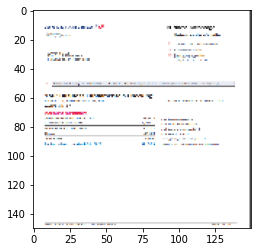

In [25]:
pred('/content/123.png')

In [ ]:
!wget 